# Variable stars use case notebook

ALeRCE starter notebook for variable star science.

You will need to install psycopg2, P4J, ipyaladin

In this notebook you will connect to the ALeRCE database, download some objects with probability greater than 0.7 of being Eclipsing variable, RR Lyrae, or some other class, get selected light curves and plot including doing period folding, as well as querying GAIA for crossmatches

### Load libraries

*External dependencies*:

psycopg2: pip install psycopg2-binary

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates

Install psycopg2 https://github.com/psycopg/psycopg2

In [25]:
#!pip install psycopg2-binary

In [26]:
import psycopg2

Install P4J https://pypi.org/project/P4J/

In [27]:
#!pip install P4J

In [28]:
import P4J

Install pyaladin https://github.com/cds-astro/ipyaladin

In [29]:
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [30]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

### Get credentials (not in github repository)

In [31]:
import json
credentials_file = "../alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [32]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

### Show all the available tables

In [33]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables

,tablename
0,class
1,asassn
2,crtsnorth
3,crtssouth
4,detections
5,insert_tmp
6,objects
7,probabilities
8,xmatch
9,features


### For each table, show column names and column types

In [34]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


### Query class numbers

In [35]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0, 'Ceph': 1, 'LPV': 4, 'RRL': 5, 'EB': 3, 'SNe': 6, 'DSCT': 2}

### Query RRL objects which have crossmatch and a classification probability >0.5

In [36]:
query='''
select probabilities.oid, objects.meanra, objects.meandec,
objects.min_magpsf_g, objects.min_magpsf_r, objects.classxmatch

from probabilities 

inner join objects
on probabilities.oid=objects.oid

where objects.classxmatch=%s and probabilities.rrl_prob>0.5
''' % classmapper["RRL"]

RRL = pd.read_sql_query(query, conn)
RRL.set_index('oid', inplace=True)
RRL.head()

,meanra,meandec,min_magpsf_g,min_magpsf_r,classxmatch
oid,,,,,
ZTF18aamfroh,219.985191,22.130840,14.473706,14.674628,5
ZTF18aagrias,228.884547,36.801879,16.163436,16.296196,5
ZTF17aabheah,140.468296,12.044092,14.988488,14.904803,5
ZTF17aacmcwm,27.791330,-13.276059,16.391448,16.350573,5
ZTF18abcmsnv,269.794473,14.800514,13.423023,13.280111,5


### Function to get period

In [37]:
# for the moment use the g band
def doperiod(LCdet):

    objperiod = {}
    freq = {}
    per = {}
    for fid in [1, 2]:
        
        maskdet = LCdet.fid == fid
        
        my_per = P4J.periodogram(method='QMIEU')
        my_per.set_data(np.array(LCdet[maskdet].mjd), np.array(LCdet[maskdet].magpsf_corr),
                        np.array(LCdet[maskdet].sigmapsf_corr))
        my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-3)
        my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=1)#10)              
        freq[fid], per[fid] = my_per.get_periodogram()
        fbest, pbest = my_per.get_best_frequencies()
        objperiod[fid] = 1. / fbest
        print(fid, objperiod[fid])

    period = objperiod[1]
    
    return period, freq, per

### Function to plot

In [38]:
def plotLC(oid, LCdet, LCnondet, dofold, period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize = (12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for idx, fid in enumerate([1, 2]):
        maskdet = LCdet.fid == fid
        masknondet = (LCnondet.fid == fid) & (LCnondet.diffmaglim > -900)
        
        if dofold:
            phase = np.mod(LCdet[maskdet].mjd, period) / period
            for nphase in [0, 1]:
                ax.errorbar(phase + nphase, LCdet[maskdet].magpsf_corr, 
                        yerr = LCdet[maskdet].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid], lw = 0)
        else:
            ax.errorbar(LCdet[maskdet].mjd, LCdet[maskdet].magpsf_corr, 
                    yerr = LCdet[maskdet].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
            ax.scatter(LCnondet[masknondet].mjd, LCnondet[masknondet].diffmaglim, c = colors[fid], alpha = 0.5,
                    marker = 'v', label = "lim.mag. %s" % labels[fid])
    if dofold:
        ax.set_title("%s (period: %.3f days" % (oid, period))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    if dofold:
        fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
        for idx, fid in enumerate([1, 2]):
            ax[idx].plot(freq[fid], per[fid])
            ax[idx].set_title("Periodogram %s" % labels[fid])
            ax[idx].set_xlabel("frequency [1/days]")

### Function to get data, fold and plot SN light curve

In [39]:
def getLCdata(oid, doplot=False, dofold=False):

    # query detections
    query = "select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    LCdet = pd.read_sql_query(query, conn)
    LCdet.sort_values(by=["mjd"], inplace=True)
        
    # query non detections
    query = "select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    LCnondet = pd.read_sql_query(query, conn)
    LCnondet.sort_values(by=["mjd"], inplace=True)

    if dofold:
        # get period
        period, freq, per = doperiod(LCdet)
    else:
        period = None; freq = None; per = None  
    
    if doplot:
        plotLC(oid, LCdet, LCnondet, dofold, period=period, freq=freq, per=per)
        
    # return data
    return LCdet, LCnondet

### Get random RRL and plot folded light curve

ZTF18abeiuep
1 [0.5057222]
2 [0.3355502]


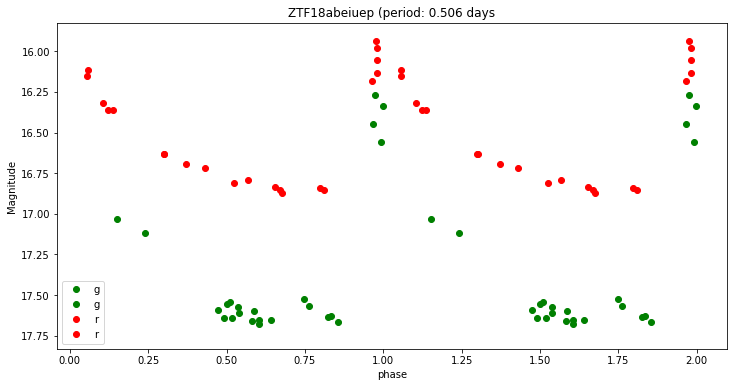

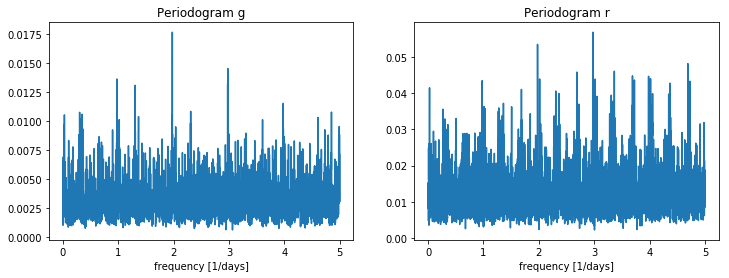

In [40]:
seloid = np.random.choice(RRL.index)
print(seloid)
LCdet, LCnondet = getLCdata(seloid, doplot = True, dofold = True);

In [41]:
aladin= ipyal.Aladin(target='%s %s' % (RRL.meanra[seloid], RRL.meandec[seloid]), fov=0.04)#, survey='P/SDSS9/color')
aladin

Aladin(fov=0.04, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…